In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

(801,)


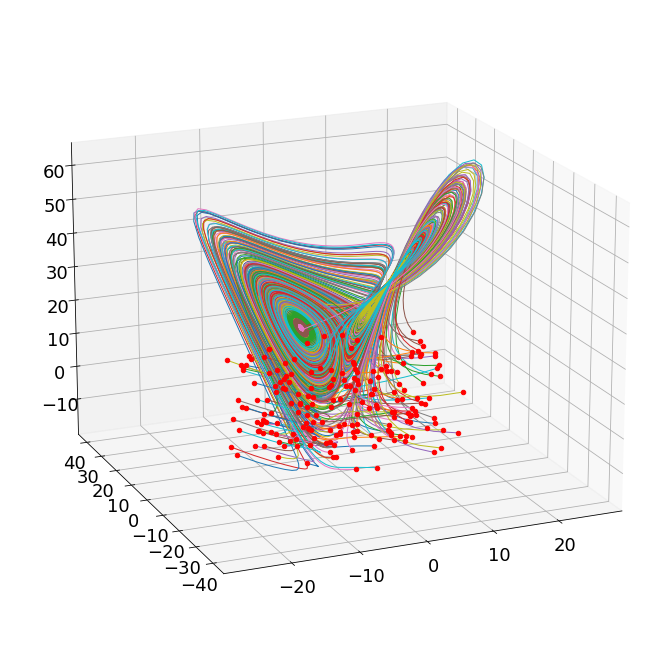

In [2]:
## Simulate the Lorenz System

dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho = 28
data_traj_num = 200

print(t.shape)

nn_input = np.zeros((data_traj_num*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((data_traj_num, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

for j in range(data_traj_num):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class my_datasets(torch.utils.data.Dataset):
    def __init__(self, X, Y,transform = None):
        self.transform = transform
        self.X = torch.from_numpy(X.astype(np.float32)).clone()
        self.Y = torch.from_numpy(Y.astype(np.float32)).clone()
        self.data_num = len(X)

    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_X = self.X[idx]
        out_Y = self.Y[idx]
        
        if self.transform:
            out_X = self.transform(X)

        return out_X, out_Y                                        

In [4]:
trainset = my_datasets(nn_input[:(len(t)-1)*50], nn_output[:(len(t)-1)*50])
testset = my_datasets(nn_input[(len(t)-1)*50:], nn_output[(len(t)-1)*50:])

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 50, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 50, shuffle = True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = nn.Linear(3,10)
        self.dense2 = nn.Linear(10,10)
        self.dense3 = nn.Linear(10,3)
    def forward(self, x):
        x = torch.sigmoid(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x

In [7]:
net = Net().to(device)

In [8]:
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

In [9]:
epochs = 1000
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    #training
    for (X,Y) in trainloader:
        X,Y = X.to(device), Y.to(device)
        optimizer.zero_grad()        
        pred = net(X)
        loss = criterion(Y,pred)
        loss.backward()
        optimizer.step()        
        train_loss += loss.item()
    
    #validation
    net.eval()
    with torch.no_grad():
        for (X,Y) in testloader:
            X,Y = X.to(device), Y.to(device)
            pred = net(X)
            loss = criterion(Y,pred)
            val_loss += loss.item()

    if epoch % 10 == 0:
        print('{:d}th epoch finished  train_loss : {:.3f}, validation_loss {:.3f}  '.format(epoch, train_loss, val_loss))    

print("Finished Training")

0th epoch finished  train_loss : 94771.009, validation_loss 68938.730  
10th epoch finished  train_loss : 418.773, validation_loss 1509.773  
20th epoch finished  train_loss : 97.989, validation_loss 419.096  
30th epoch finished  train_loss : 35.519, validation_loss 181.629  
40th epoch finished  train_loss : 17.223, validation_loss 107.531  
50th epoch finished  train_loss : 10.625, validation_loss 70.083  
60th epoch finished  train_loss : 8.215, validation_loss 53.438  
70th epoch finished  train_loss : 6.574, validation_loss 47.657  
80th epoch finished  train_loss : 5.288, validation_loss 34.964  
90th epoch finished  train_loss : 5.163, validation_loss 31.405  
100th epoch finished  train_loss : 4.587, validation_loss 26.321  
110th epoch finished  train_loss : 4.292, validation_loss 28.163  
120th epoch finished  train_loss : 4.282, validation_loss 24.793  
130th epoch finished  train_loss : 3.858, validation_loss 21.014  
140th epoch finished  train_loss : 3.656, validation_lo

In [10]:
np.random.seed(139)
num_traj = 3

nn_flow = np.zeros((num_traj, len(t), 3))
nn_flow[:, 0, :] =  -15 + 30 * np.random.random((num_traj, 3))
nn_flow = torch.from_numpy(nn_flow.astype(np.float32)).clone().to(device)
for jj, tval in enumerate(t[:-1]):
    nn_flow[:, jj+1, :] = net(nn_flow[:, jj, :])
nn_flow = nn_flow.to('cpu').detach().numpy().copy()
x_t = np.array([integrate.odeint(lorenz_deriv, nn_flow[i, 0, :], t) for i in range(num_traj)])

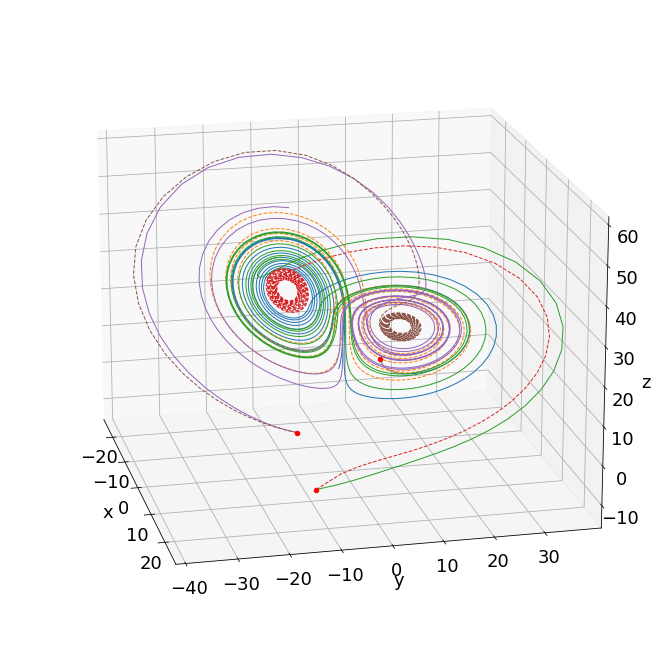

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(num_traj):
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = nn_flow[j, :, :].T
    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x[0], y[0], z[0], color='r')
             
ax.view_init(18, -13)
plt.show()